In [6]:
using Random, NLopt, LinearAlgebra, Interpolations, Base.Threads, DataFrames
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions, Profile
using DataFrames, Measures, StatsBase, LaTeXStrings, Printf

In [24]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

function create_focused_grid(a_min::Float64, a_focus::Float64, a_max::Float64, Na::Int, focus_share::Float64, curv::Float64)
    Na_focus = ceil(Int, Na * focus_share)
    Na_rest = Na - Na_focus
    grid_focus = nonlinspace(a_min, a_focus, Na_focus, curv)
    grid_rest = nonlinspace(a_focus, a_max, Na_rest + 1, curv)[2:end]
    return vcat(grid_focus, grid_rest)
end

# -------------------------------
# Dynamic Family Model Definition
# -------------------------------
using Random

mutable struct FamilyModel
    # --- Model Parameters ---
    T::Int                        # Number of periods
    beta::Float64                 # Discount factor
    phi_1::Float64                # Parent's disutility of labor
    phi_2::Float64                # Parent's utility from human capital
    phi_3::Float64                # Parent's utility from consumption
    R::Float64                    # Human capital technology parameter
    sigma_1::Float64              # Elasticity: HC w.r.t. child care time
    sigma_3::Float64              # Elasticity: HC w.r.t. investment
    sigma_4::Float64              # Elasticity: HC w.r.t. current human capital
    tau::Float64                  # Labor income tax
    r::Float64                    # Interest rate
    y::Float64                    # Unearned income
    a_max::Float64                # Max asset level
    a_min::Float64                # Min asset level
    Na::Int                       # Asset grid size
    k_max::Float64                # Max physical capital
    k_min::Float64                # Min physical capital
    Nk::Int                       # Physical capital grid size
    hc_max::Float64               # Max human capital (for child/parent)
    hc_min::Float64               # Min human capital
    Nhc::Int                      # Human capital grid size
    alpha::Float64                # Parameter in wage function
    psi_terminal::Float64         # importance of terminal HC

    # --- Grids ---
    a_grid::Vector{Float64}       # Asset grid
    k_grid::Vector{Float64}       # Physical capital grid
    hc_grid::Vector{Float64}      # Human capital grid

    # --- Solution Arrays (for value function iteration) ---
    sol_c::Array{Float64,4}       # Parental consumption    [T, Na, Nk, Nhc]
    sol_h::Array{Float64,4}       # Parental labor supply   [T, Na, Nk, Nhc]
    sol_t::Array{Float64,4}       # Child care time         [T, Na, Nk, Nhc]
    sol_e::Array{Float64,4}       # Education expenditure   [T, Na, Nk, Nhc]
    sol_v::Array{Float64,4}       # Value function          [T, Na, Nk, Nhc]

    # --- Simulation Storage ---
    simN::Int                     # Number of simulated agents
    simT::Int                     # Number of simulation periods
    sim_c::Array{Float64,2}       # Simulated consumption   [simN, simT]
    sim_h::Array{Float64,2}       # Simulated labor         [simN, simT]
    sim_t::Array{Float64,2}       # Simulated child care    [simN, simT]
    sim_e::Array{Float64,2}       # Simulated education exp [simN, simT]
    sim_a::Array{Float64,2}       # Simulated assets        [simN, simT]
    sim_k::Array{Float64,2}       # Simulated capital       [simN, simT]
    sim_hc::Array{Float64,2}      # Simulated human capital [simN, simT]

    # --- Initial conditions ---
    sim_a_init::Vector{Float64}   # Initial assets          [simN]
    sim_k_init::Vector{Float64}   # Initial capital         [simN]
    sim_hc_init::Vector{Float64}  # Initial human capital   [simN]

    # --- Wage vector (for each period) ---
    w_vec::Vector{Float64}        # Wage per period         [T]
end

function FamilyModel(; T::Int=5, beta::Float64=0.97,
                        phi_1::Float64=0.35, phi_2::Float64=0.38, phi_3::Float64=0.27,
                        R::Float64=1.0, sigma_1::Float64=0.15,
                        sigma_3::Float64=0.05, sigma_4::Float64=0.8,
                        tau::Float64=0.25, r::Float64=0.03,
                        y::Float64=0.0, a_max::Float64=1e5,
                        a_min::Float64=1e-2, Na::Int=30, psi_terminal::Float64=1.5,
                        k_max::Float64=30.0, k_min::Float64=1e-2, Nk::Int=30,
                        hc_max::Float64=10.0, hc_min::Float64=1e-2, Nhc::Int=30,
                        simN::Int=5000, simT::Int=T, alpha::Float64=0.08, seed::Int=1234)

    # Grids (custom grid functions)
    a_grid = create_focused_grid(a_min, 60_000.0, a_max, Na, 0.7, 1.2)
    #a_grid = nonlinspace(a_min, a_max, Na, 1.2)
    k_grid = nonlinspace(k_min, k_max, Nk, 1.2)
    hc_grid = nonlinspace(hc_min, hc_max, Nhc, 1.2)

    # Solution arrays (4D: [T, Na, Nk, Nhc])
    sol_shape = (T, Na, Nk, Nhc)
    sol_c = fill(NaN, sol_shape)
    sol_h = fill(NaN, sol_shape)
    sol_t = fill(NaN, sol_shape)
    sol_e = fill(NaN, sol_shape)
    sol_v = fill(NaN, sol_shape)

    # Simulation arrays (2D: [simN, simT])
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_t = fill(NaN, sim_shape)
    sim_e = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)
    sim_hc = fill(NaN, sim_shape)

    # Initial conditions
    sim_a_init = zeros(Float64, simN)
    sim_k_init = fill(k_min, simN)
    sim_hc_init = fill(hc_min, simN)

    # Wage vector
    w_vec = fill(12.5, T)

    return FamilyModel(T, beta, phi_1, phi_2, phi_3, R, sigma_1, sigma_3, sigma_4,
                      tau, r, y, a_max, a_min, Na, k_max, k_min, Nk, hc_max, hc_min, Nhc, alpha, psi_terminal,
                      a_grid, k_grid, hc_grid,
                      sol_c, sol_h, sol_t, sol_e, sol_v,
                      simN, simT, sim_c, sim_h, sim_t, sim_e, sim_a, sim_k, sim_hc,
                      sim_a_init, sim_k_init, sim_hc_init,
                      w_vec)
end

FamilyModel

In [25]:
# --------------------------
# Model Solver
# --------------------------
# Solve the model with parallelization and constraints
function solve_model!(model::FamilyModel)
    T, Na, Nk, Nhc = model.T, model.Na, model.Nk, model.Nhc
    a_grid, k_grid, hc_grid = model.a_grid, model.k_grid, model.hc_grid
    # Save to model arrays
    for i_a in 1:Na
        for i_k in 1:Nk
            for i_hc in 1:Nhc
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                HC = hc_grid[i_hc]

                # Objective wrapper for NLopt
                function obj_last(x::Vector, grad::Vector)
                    e_p, h_p, t_p = x[1], x[2], x[3]
                    return obj_last_period(model, e_p, h_p, t_p, assets, HC, capital, T)
                end

                opt = Opt(:LN_COBYLA, 3)
                lower_bounds!(opt, [1e-6, 0.0, 0.0])  # e_p > 0, h_p >= 0, t_p >= 0
                upper_bounds!(opt, [Inf, 1.0, 1.0])   # For example, h_p and t_p <= 1
                inequality_constraint!(opt, constraint_min_leisure, 1e-6)
                min_objective!(opt, obj_last)
                init = [2000.0, 0.4, 0.4]  # Reasonable initial guess

                ftol_rel!(opt, 1e-6)
                maxeval!(opt, 10000)
                (minf, x_opt, ret) = optimize(opt, init)

                # Store solutions
                model.sol_e[T, i_a, i_k, i_hc] = x_opt[1]
                model.sol_h[T, i_a, i_k, i_hc] = x_opt[2]
                model.sol_t[T, i_a, i_k, i_hc] = x_opt[3]
                model.sol_c[T, i_a, i_k, i_hc] = a_grid[i_a] + wage_func(model, k_grid[i_k], T) * x_opt[2] + model.y - x_opt[1]
                model.sol_v[T, i_a, i_k, i_hc] = -minf
            end
        end
    end


    # Earlier periods (t = T-1 to 1)
    for t in (T-1):-1:1
        println("Solving period $t ...")
        # Build the value function interpolator for period t+1
        interp = create_interp(model, model.sol_v, t+1)  # <-- only once per period


        for i_a in 1:Na
            for i_k in 1:Nk
                for i_hc in 1:Nhc
                    assets = a_grid[i_a]
                    capital = k_grid[i_k]
                    HC = hc_grid[i_hc]

                    # Objective wrapper for NLopt
                    function obj_work(x::Vector, grad::Vector)
                        c_p, e_p, h_p, t_p = x[1], x[2], x[3], x[4]
                        return obj_work_period(model, c_p, e_p, h_p, t_p, assets, HC, capital, t, interp)
                    end

                    opt = Opt(:LN_COBYLA, 4)
                    lower_bounds!(opt, [1e-6, 1e-6, 0.0, 0.0])  # c_p > 0, e_p > 0, h_p ≥ 0, t_p ≥ 0
                    upper_bounds!(opt, [Inf, Inf, 1.0, 1.0])     # Example upper bounds
                    inequality_constraint!(opt, constraint_min_leisure, 1e-6)
                    min_objective!(opt, obj_work)
                    # Initial guess: use future period solution if available, else reasonable guess
                    init = [model.sol_c[t+1, i_a, i_k, i_hc],
                            model.sol_e[t+1, i_a, i_k, i_hc],
                            min(model.sol_h[t+1, i_a, i_k, i_hc], 0.5),
                            min(model.sol_t[t+1, i_a, i_k, i_hc], 0.5)]

                    ftol_rel!(opt, 1e-6)
                    maxeval!(opt, 10000)
                    (minf, x_opt, ret) = optimize(opt, init)

                    # Store solutions
                    model.sol_c[t, i_a, i_k, i_hc] = x_opt[1]
                    model.sol_e[t, i_a, i_k, i_hc] = x_opt[2]
                    model.sol_h[t, i_a, i_k, i_hc] = x_opt[3]
                    model.sol_t[t, i_a, i_k, i_hc] = x_opt[4]
                    model.sol_v[t, i_a, i_k, i_hc] = -minf
                end
            end
        end
    end
end


# ------------------------------------------------
# Supporting functions 
# ------------------------------------------------
function constraint_min_leisure(x::Vector, grad::Vector)
    n = length(x)
    h_p = x[n-1]
    t_p = x[n]
    leisure = 1.0 - h_p - t_p
    if length(grad) > 0
        grad .= 0.0
        grad[n-1] = -1.0
        grad[n]   = -1.0
    end
    return -leisure + 0.1   # ensures leisure ≥ 0.1
end

function obj_last_period(
    model::FamilyModel, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, HC::Float64, capital::Float64, t::Int
)
    # Wage and income
    income = wage_func(model, capital, t) * h_p
    c = assets + income + model.y - e_p

    # Penalties (same as before)
    penalty_c = c < 0.0 ? (abs(c)^2) * 1e10 : 0.0
    penalty_h = h_p < 0.0 ? (abs(h_p)^2) * 1e10 : 0.0
    penalty_e = e_p < 0.0 ? (abs(e_p)^2) * 1e10 : 0.0
    penalty_t = t_p < 0.0 ? (abs(t_p)^2) * 1e10 : 0.0
    penalty_time = (h_p + t_p > 1.0) ? (h_p + t_p - 1.0)^2 * 1e10 : 0.0

    # Utility in the last period
    util_now = util_parent(model, c, h_p, t_p, HC)
    # Calculate next period's HC, since investments affect it
    HC_next = HC_technology(model, t_p, e_p, HC)

    # Add terminal value of HC_next (child's final human capital)
    terminal = terminal_value(model, HC_next)

    return -(util_now + terminal - penalty_c - penalty_h - penalty_e - penalty_t - penalty_time)
end


function obj_work_period(
    model::FamilyModel,
    c_p::Float64, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, HC::Float64, capital::Float64, t::Int, interp
)
    # Budget and law of motion
    income = wage_func(model, capital, t) * h_p
    a_next = (1.0 + model.r) * assets + income + model.y - c_p - e_p

    # Penalties for feasibility
    penalty_c = c_p < 0.0 ? (abs(c_p)^2) * 1e10 : 0.0
    penalty_h = h_p < 0.0 ? (abs(h_p)^2) * 1e10 : 0.0
    penalty_e = e_p < 0.0 ? (abs(e_p)^2) * 1e10 : 0.0
    penalty_t = t_p < 0.0 ? (abs(t_p)^2) * 1e10 : 0.0
    penalty_a = a_next < model.a_min ? (abs(model.a_min - a_next)^2) * 1e10 : 0.0
    penalty_time = (h_p + t_p > 1.0) ? (h_p + t_p)^2 * 1e10 : 0.0

    util_now = util_parent(model, c_p, h_p, t_p, HC)
    HC_next = HC_technology(model, t_p, e_p, HC)         # Edit 1.0 if you have an I or other investment input
    k_next = capital + h_p                               # Or use your capital law of motion

    # Interpolate future value
    V_next = interp(a_next, k_next, HC_next)

    return -(util_now + model.beta * V_next - penalty_a - penalty_c - penalty_h - penalty_e - penalty_t - penalty_time) # minus for minimization
end





@inline function util_parent(model::FamilyModel, c, h_p, t_p, k)
    leisure = 1.0 - h_p - t_p
    if leisure <= 0.0
        return -Inf  # Prevent invalid leisure values
    end
    return model.phi_3 * log(c) + model.phi_1 * log(leisure) + model.phi_2 * log(k)
end

@inline function HC_technology(model::FamilyModel, t_p, e_p, k)
    # Returns the technology level for child care
    #return log(model.R) + model.sigma_1 * log(t_p) + model.sigma_3 * log(I) + model.sigma_4 * log(k) #  + model.sigma_2 * log(t_c)
    return model.R * t_p^model.sigma_1 * e_p^model.sigma_3 * k^model.sigma_4
end


@inline function terminal_value(model::FamilyModel, k)
    return model.psi_terminal * log(k)  # or just k if you want linear
end


@inline function wage_func(model::FamilyModel, capital::Float64, t::Int)
    # Compute the effective wage: after tax wage rate adjusted for capital effects.
    return (1 - model.tau) * model.w_vec[t]  * 5840 # * (1.0 + model.alpha * capital)
end

# Interpolation helper function


function create_interp(model::FamilyModel, sol_v, t)
    itp = interpolate(
        (model.a_grid, model.k_grid, model.hc_grid),
        sol_v[t, :, :, :],
        Gridded(Linear())  # Only Linear (or Constant) is supported with Gridded
    )
    return extrapolate(itp, Line())  # Linear extrapolation
end

create_interp (generic function with 1 method)

In [26]:
model_baseline = FamilyModel()

solve_model!(model_baseline)

Solving period 4 ...
Solving period 3 ...
Solving period 2 ...
Solving period 1 ...


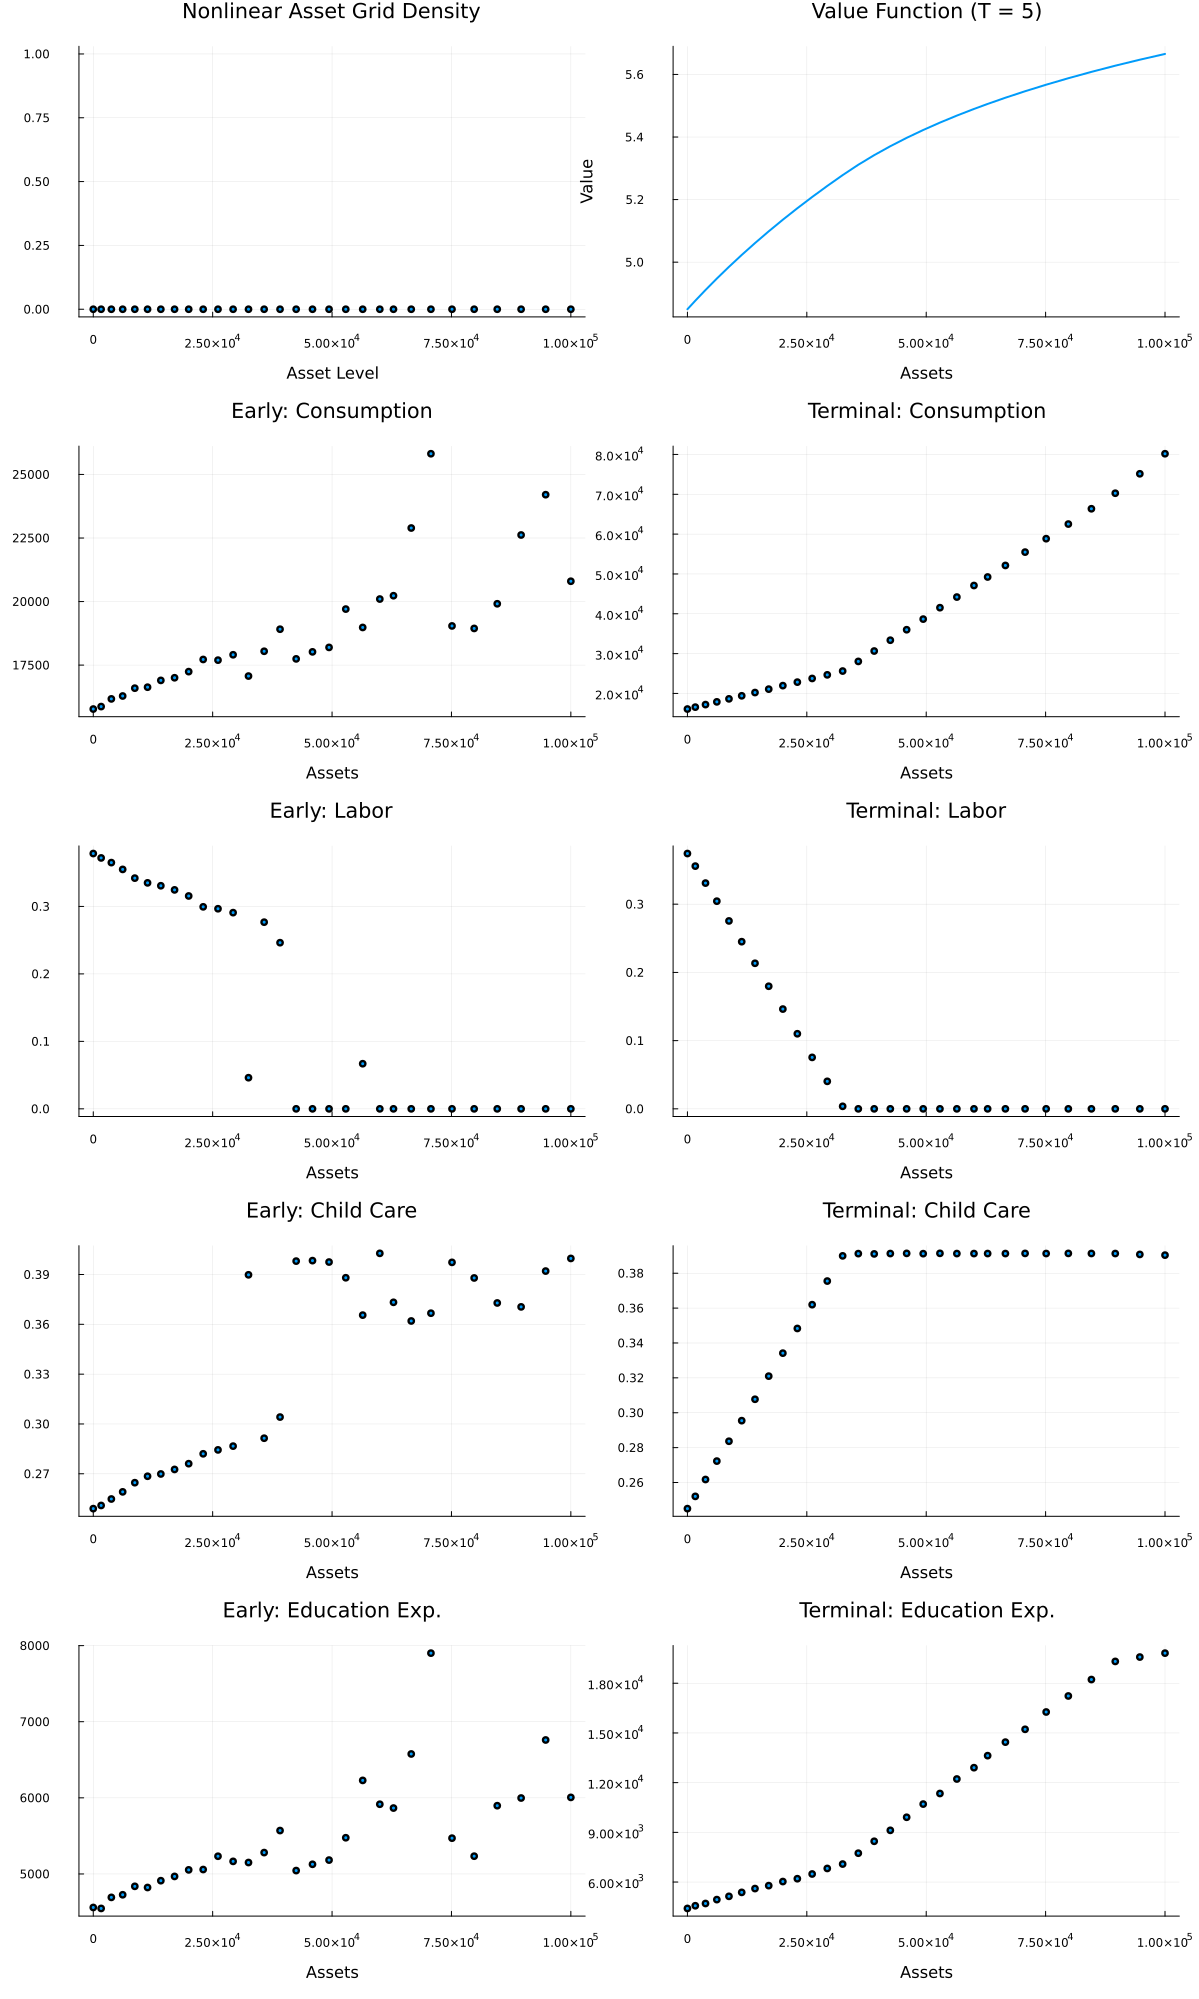

In [27]:
# Indices
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
T_terminal = model_baseline.T
t_early = 1
a_grid = model_baseline.a_grid

# 1. Nonlinear asset grid (early/terminal concept doesn't apply—repeat for both columns)
p1 = scatter(
    a_grid,
    zeros(length(a_grid)),
    xlabel = "Asset Level",
    ylabel = "",
    title = "Nonlinear Asset Grid Density",
    markersize = 3,
    legend = false,
)
p2 = plot(
    a_grid,
    model_baseline.sol_v[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2,
)

# 2. Consumption
p3 = scatter(
    a_grid, model_baseline.sol_c[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Consumption",
    title = "Early: Consumption", label = "cₜ(a)", markersize = 3)
p4 = scatter(
    a_grid, model_baseline.sol_c[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Consumption", label = "cₜ(a)", markersize = 3)

# 3. Labor
p5 = scatter(
    a_grid, model_baseline.sol_h[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Labor",
    title = "Early: Labor", label = "hₜ(a)", markersize = 3)
p6 = scatter(
    a_grid, model_baseline.sol_h[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Labor", label = "hₜ(a)", markersize = 3)

# 4. Child care time
p7 = scatter(
    a_grid, model_baseline.sol_t[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Child Care",
    title = "Early: Child Care", label = "tₜ(a)", markersize = 3)
p8 = scatter(
    a_grid, model_baseline.sol_t[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Child Care", label = "tₜ(a)", markersize = 3)

# 5. Education expenditure
p9 = scatter(
    a_grid, model_baseline.sol_e[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Education Exp.",
    title = "Early: Education Exp.", label = "eₜ(a)", markersize = 3)
    
p10 = scatter(
    a_grid, model_baseline.sol_e[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Education Exp.", label = "eₜ(a)", markersize = 3)

# Combine all plots into a 5×2 grid
plot(
    p1, p2,
    p3, p4,
    p5, p6,
    p7, p8,
    p9, p10,
    layout = (5, 2),
    size = (1200, 2000),
    margin = 3mm,
    legend = false
)

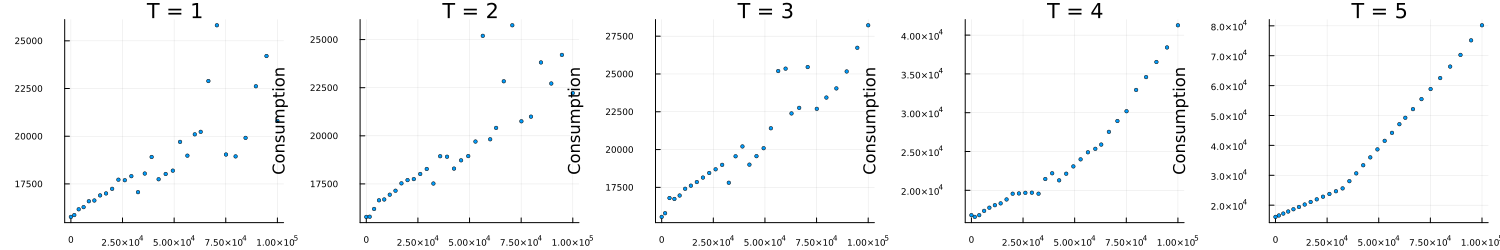

In [28]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_c
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid, hc_mid],
        xlabel = "Assets",
        ylabel = "Consumption",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))

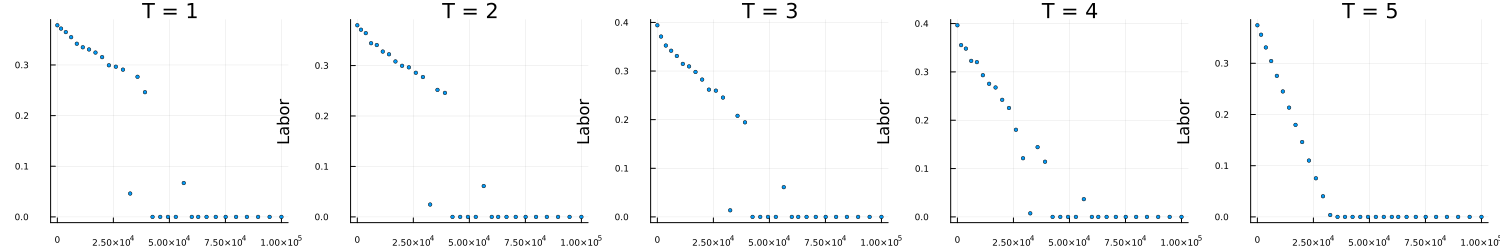

In [29]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_h
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid, hc_mid],
        xlabel = "Assets",
        ylabel = "Labor",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))

In [42]:


# --------------------------
# Model Solver
# --------------------------
function solve_model!(model::FamilyModel)
    T, Na, Nk, Nhc = model.T, model.Na, model.Nk, model.Nhc
    a_grid, k_grid, hc_grid = model.a_grid, model.k_grid, model.hc_grid
    # Last period (t = T)
    for i_a in 1:Na
        for i_k in 1:Nk
            for i_hc in 1:Nhc
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                HC = hc_grid[i_hc]

                # Objective wrapper for NLopt
                function obj_last(x::Vector, grad::Vector)
                    e_p, h_p, t_p = x[1], x[2], x[3]
                    return obj_last_period(model, e_p, h_p, t_p, assets, HC, capital, T, grad)
                end

                opt = Opt(:LD_SLSQP, 3)
                lower_bounds!(opt, [1e-6, 0.0, 0.0])  # e_p > 0, h_p >= 0, t_p >= 0
                upper_bounds!(opt, [Inf, 1.0, 1.0])   # h_p and t_p <= 1
                #inequality_constraint!(opt, constraint_time, 1e-10)
                min_objective!(opt, obj_last)
                init = [2000.0, 0.4, 0.3]  # Reasonable initial guess

                ftol_rel!(opt, 1e-6)
                maxeval!(opt, 10000)
                (minf, x_opt, ret) = optimize(opt, init)

                # Store solutions
                model.sol_e[T, i_a, i_k, i_hc] = x_opt[1]
                model.sol_h[T, i_a, i_k, i_hc] = x_opt[2]
                model.sol_t[T, i_a, i_k, i_hc] = x_opt[3]
                model.sol_c[T, i_a, i_k, i_hc] = a_grid[i_a] + wage_func(model, k_grid[i_k], T) * x_opt[2] + model.y - x_opt[1]
                model.sol_v[T, i_a, i_k, i_hc] = -minf
            end
        end
    end

    # Earlier periods (t = T-1 to 1)
    for t in (T-1):-1:1
        println("Solving period $t ...")
        # Build the value function interpolator for period t+1
        interp = create_interp(model, model.sol_v, t+1)

        for i_a in 1:Na
            for i_k in 1:Nk
                for i_hc in 1:Nhc
                    assets = a_grid[i_a]
                    capital = k_grid[i_k]
                    HC = hc_grid[i_hc]

                    # Objective wrapper for NLopt
                    function obj_work(x::Vector, grad::Vector)
                        c_p, e_p, h_p, t_p = x[1], x[2], x[3], x[4]
                        return obj_work_period(model, c_p, e_p, h_p, t_p, assets, HC, capital, t, interp, grad)
                    end

                    opt = Opt(:LD_SLSQP, 4)
                    lower_bounds!(opt, [1e-6, 1e-6, 0.0, 0.0])  # c_p > 0, e_p > 0, h_p >= 0, t_p >= 0
                    upper_bounds!(opt, [Inf, Inf, 1.0, 1.0])    # Example upper bounds
                    #inequality_constraint!(opt, constraint_time, 1e-10)
                    min_objective!(opt, obj_work)
                    init = [model.sol_c[t+1, i_a, i_k, i_hc],
                            model.sol_e[t+1, i_a, i_k, i_hc],
                            min(model.sol_h[t+1, i_a, i_k, i_hc], 0.5),
                            min(model.sol_t[t+1, i_a, i_k, i_hc], 0.5)]

                    ftol_rel!(opt, 1e-6)
                    maxeval!(opt, 10000)
                    (minf, x_opt, ret) = optimize(opt, init)

                    # Store solutions
                    model.sol_c[t, i_a, i_k, i_hc] = x_opt[1]
                    model.sol_e[t, i_a, i_k, i_hc] = x_opt[2]
                    model.sol_h[t, i_a, i_k, i_hc] = x_opt[3]
                    model.sol_t[t, i_a, i_k, i_hc] = x_opt[4]
                    model.sol_v[t, i_a, i_k, i_hc] = -minf
                end
            end
        end
    end
end

# ------------------------------------------------
# Supporting Functions
# ------------------------------------------------
function constraint_time(x::Vector, grad::Vector)
    n = length(x)
    h_p = x[n-1]
    t_p = x[n]
    if length(grad) > 0
        grad .= 0.0
        grad[n-1] = 1.0  # ∂/∂h_p
        grad[n]   = 1.0  # ∂/∂t_p
    end
    return h_p + t_p - 1.0  # ≤ 0
end

function obj_last_period(
    model::FamilyModel, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, HC::Float64, capital::Float64, t::Int, grad::Vector
)
    w = wage_func(model, capital, t)
    income = w * h_p
    c = assets + income + model.y - e_p

    util_now = c > 0 && h_p + t_p < 1 ? util_parent(model, c, h_p, t_p, capital) : -Inf
    penalty_c = c < 0.0 ? (c^2) * 1e10 : 0.0
    penalty_h = h_p < 0.0 ? (h_p^2) * 1e10 : 0.0
    penalty_e = e_p < 0.0 ? (e_p^2) * 1e10 : 0.0
    penalty_t = t_p < 0.0 ? (t_p^2) * 1e10 : 0.0
    penalty_time = (h_p + t_p > 1.0) ? (h_p + t_p - 1.0)^2 * 1e10 : 0.0

    if length(grad) > 0
        dutil_de = c > 0 ? -model.phi_3 / c : 0.0
        dutil_dh = c > 0 && h_p + t_p < 1 ? (model.phi_3 / c) * w - model.phi_1 / (1 - h_p - t_p) : 0.0
        dutil_dt = h_p + t_p < 1 ? -model.phi_1 / (1 - h_p - t_p) : 0.0

        dpenalty_c_de = c < 0.0 ? 2 * c * (-1) * 1e10 : 0.0
        dpenalty_c_dh = c < 0.0 ? 2 * c * w * 1e10 : 0.0
        dpenalty_h_dh = h_p < 0.0 ? 2 * h_p * 1e10 : 0.0
        dpenalty_e_de = e_p < 0.0 ? 2 * e_p * 1e10 : 0.0
        dpenalty_t_dt = t_p < 0.0 ? 2 * t_p * 1e10 : 0.0
        dpenalty_time_dh = (h_p + t_p > 1.0) ? 2 * (h_p + t_p - 1.0) * 1e10 : 0.0
        dpenalty_time_dt = (h_p + t_p > 1.0) ? 2 * (h_p + t_p - 1.0) * 1e10 : 0.0

        grad[1] = - (dutil_de - dpenalty_c_de - dpenalty_e_de)
        grad[2] = - (dutil_dh - dpenalty_c_dh - dpenalty_h_dh - dpenalty_time_dh)
        grad[3] = - (dutil_dt - dpenalty_t_dt - dpenalty_time_dt)
    end

    return -(util_now - penalty_c - penalty_h - penalty_e - penalty_t - penalty_time)
end

function obj_work_period(
    model::FamilyModel,
    c_p::Float64, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, HC::Float64, capital::Float64, t::Int, interp, grad::Vector
)
    w = wage_func(model, capital, t)
    income = w * h_p
    a_next = (1.0 + model.r) * assets + income + model.y - c_p - e_p
    k_next = capital + h_p
    HC_next = HC_technology(model, t_p, e_p, HC)

    # Utility
    util_now = c_p > 0 && h_p < 1 ? util_parent(model, c_p, h_p, t_p, HC) : -Inf
    # Penalties
    penalty_c = c_p < 0.0 ? (c_p^2) * 1e10 : 0.0
    penalty_h = h_p < 0.0 ? (h_p^2) * 1e10 : 0.0
    penalty_e = e_p < 0.0 ? (e_p^2) * 1e10 : 0.0
    penalty_t = t_p < 0.0 ? (t_p^2) * 1e10 : 0.0
    penalty_a = a_next < model.a_min ? (model.a_min - a_next)^2 * 1e10 : 0.0
    penalty_time = (h_p + t_p > 1.0) ? (h_p + t_p - 1.0)^2 * 1e10 : 0.0

    # Future value
    V_next = interp(a_next, k_next, HC_next)

    # Compute gradients if requested
    if length(grad) > 0
        # Utility gradients
        dutil_dc = c_p > 0 ? model.phi_3 / c_p : 0.0
        dutil_dh = h_p < 1 ? -model.phi_1 / (1 - h_p) : 0.0
        dutil_de = 0.0
        dutil_dt = 0.0

        # Penalty gradients
        dpenalty_c_dc = c_p < 0.0 ? 2 * c_p * 1e10 : 0.0
        dpenalty_h_dh = h_p < 0.0 ? 2 * h_p * 1e10 : 0.0
        dpenalty_e_de = e_p < 0.0 ? 2 * e_p * 1e10 : 0.0
        dpenalty_t_dt = t_p < 0.0 ? 2 * t_p * 1e10 : 0.0
        dpenalty_a_da = a_next < model.a_min ? -2 * (model.a_min - a_next) * 1e10 : 0.0
        dpenalty_time_dh = (h_p + t_p > 1.0) ? 2 * (h_p + t_p - 1.0) * 1e10 : 0.0
        dpenalty_time_dt = (h_p + t_p > 1.0) ? 2 * (h_p + t_p - 1.0) * 1e10 : 0.0

        # Future value gradients (via interpolation)
        dV_da, dV_dk, dV_dhc = Interpolations.gradient(interp, a_next, k_next, HC_next)

        # HC_next gradients
        dHC_dt = t_p > 0 ? model.sigma_1 / t_p : 0.0
        dHC_de = e_p > 0 ? model.sigma_3 / e_p : 0.0

        # Chain rule for a_next: ∂a_next/∂c_p = -1, ∂a_next/∂e_p = -1, ∂a_next/∂h_p = w
        dV_dc = dV_da * (-1)
        dV_de = dV_da * (-1) + dV_dhc * dHC_de
        dV_dh = dV_da * w + dV_dk * 1
        dV_dt = dV_dhc * dHC_dt

        # Total gradient: - (∂util + β ∂V - ∂penalties)
        grad[1] = - (dutil_dc + model.beta * dV_dc - dpenalty_c_dc)                  # ∂/∂c_p
        grad[2] = - (dutil_de + model.beta * dV_de - dpenalty_e_de)                  # ∂/∂e_p
        grad[3] = - (dutil_dh + model.beta * dV_dh - dpenalty_h_dh - dpenalty_time_dh)  # ∂/∂h_p
        grad[4] = - (dutil_dt + model.beta * dV_dt - dpenalty_t_dt - dpenalty_time_dt)  # ∂/∂t_p
    end

    return -(util_now + model.beta * V_next - penalty_a - penalty_c - penalty_h - penalty_e - penalty_t - penalty_time)
end

@inline function util_parent(model::FamilyModel, c, h_p, t_p, k)
    leisure = 1.0 - h_p - t_p
    if leisure <= 0.0
        return -Inf  # Prevent invalid leisure values
    end
    return model.phi_3 * log(c) + model.phi_1 * log(leisure) + model.phi_2 * log(k)
end

@inline function HC_technology(model::FamilyModel, t_p, e_p, k)
    #return log(model.R) + model.sigma_1 * log(t_p) + model.sigma_3 * log(I) + model.sigma_4 * log(k)
    return model.R * t_p^model.sigma_1 * e_p^model.sigma_3 * k^model.sigma_4
end

@inline function wage_func(model::FamilyModel, capital::Float64, t::Int)
    return (1 - model.tau) * model.w_vec[t] * 5840
end

function create_interp(model::FamilyModel, sol_v, t)
    itp = interpolate((model.a_grid, model.k_grid, model.hc_grid), sol_v[t, :, :, :], Gridded(Linear()))
    return extrapolate(itp, Line())
end

create_interp (generic function with 1 method)

In [43]:
model_baseline = FamilyModel()

solve_model!(model_baseline)

Solving period 4 ...
Solving period 3 ...
Solving period 2 ...
Solving period 1 ...


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


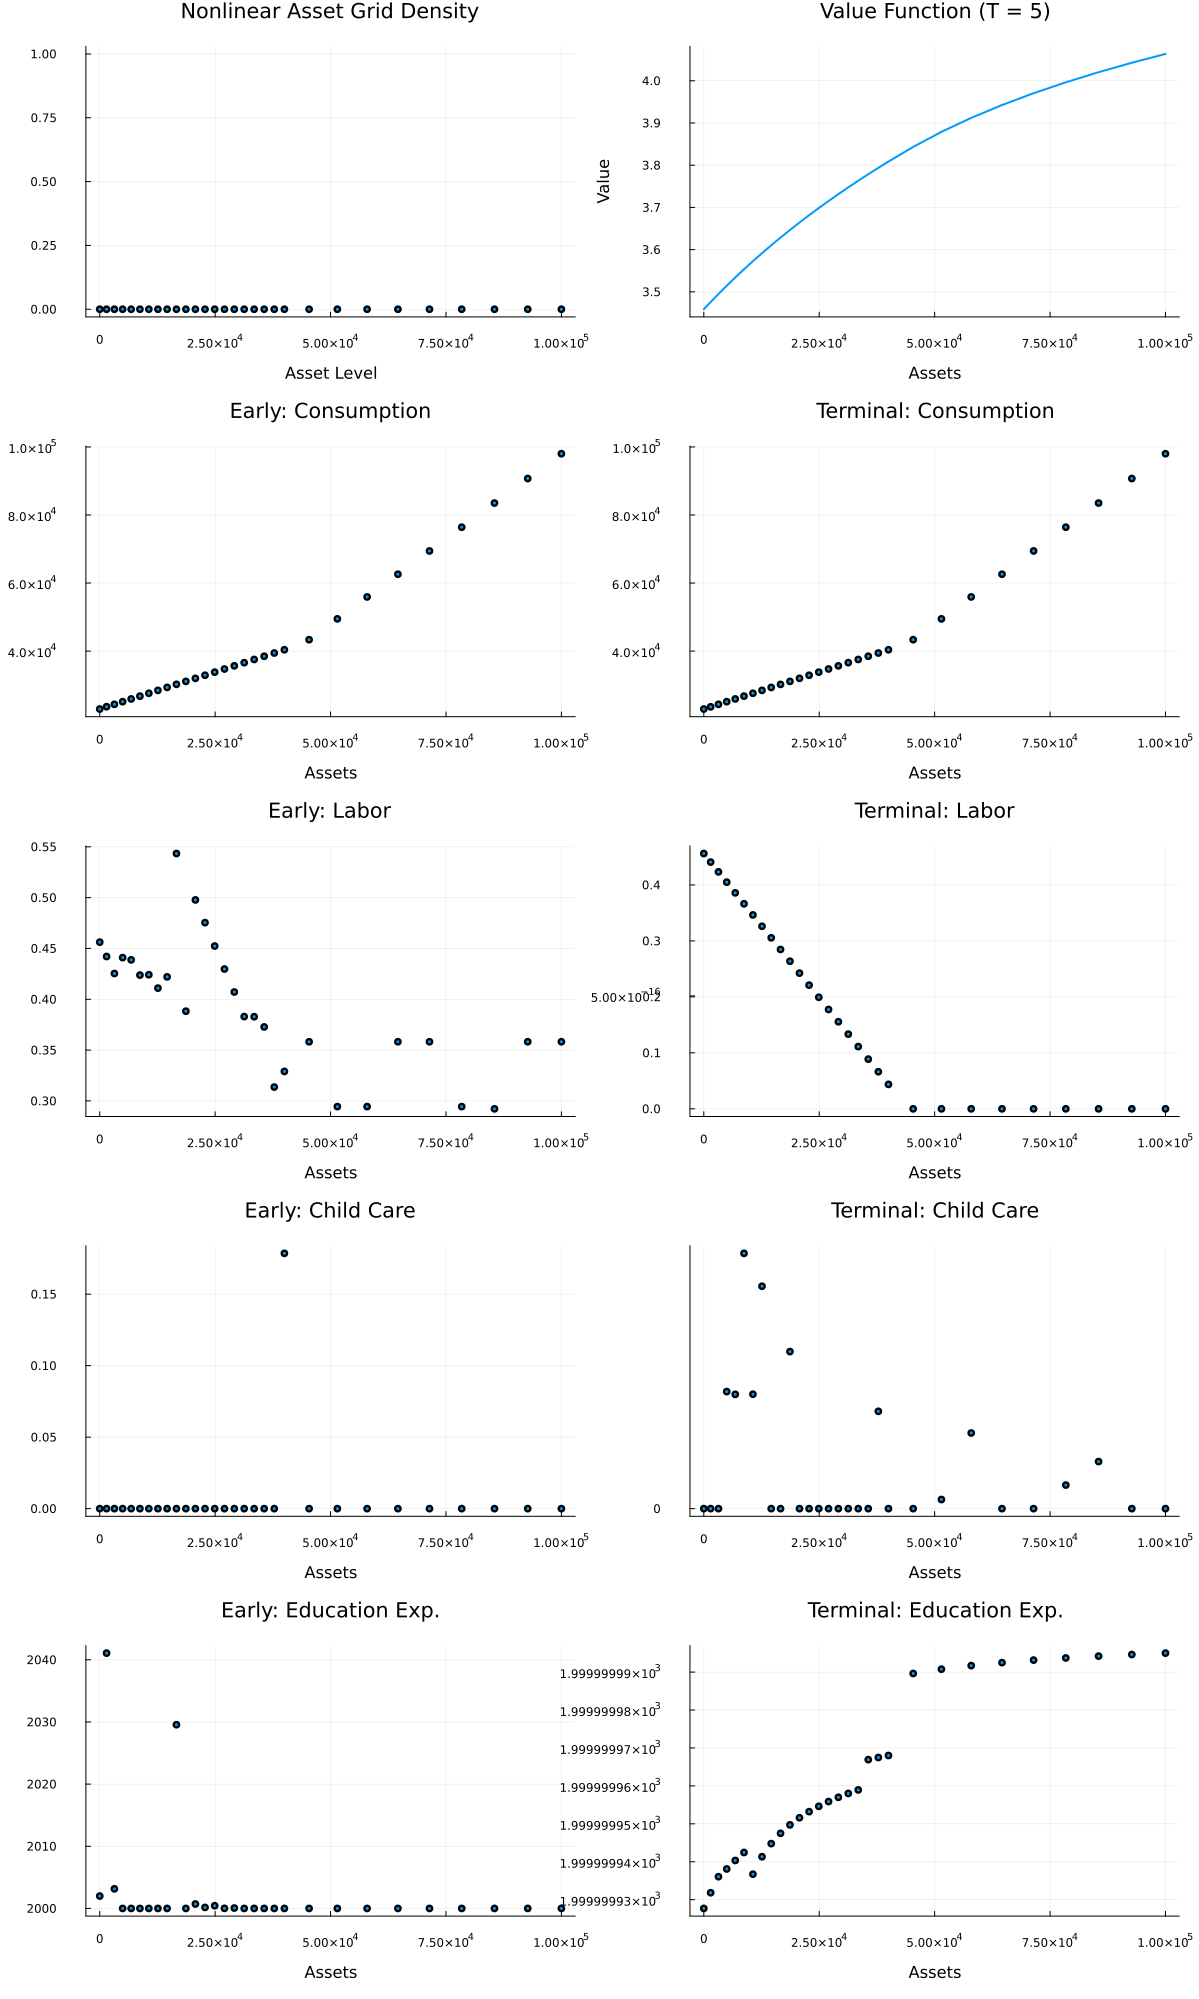

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [44]:
using Plots

# Indices
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
T_terminal = model_baseline.T
t_early = 1
a_grid = model_baseline.a_grid

# 1. Nonlinear asset grid (early/terminal concept doesn't apply—repeat for both columns)
p1 = scatter(
    a_grid,
    zeros(length(a_grid)),
    xlabel = "Asset Level",
    ylabel = "",
    title = "Nonlinear Asset Grid Density",
    markersize = 3,
    legend = false,
)
p2 = plot(
    a_grid,
    model_baseline.sol_v[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2,
)

# 2. Consumption
p3 = scatter(
    a_grid, model_baseline.sol_c[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Consumption",
    title = "Early: Consumption", label = "cₜ(a)", markersize = 3)
p4 = scatter(
    a_grid, model_baseline.sol_c[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Consumption", label = "cₜ(a)", markersize = 3)

# 3. Labor
p5 = scatter(
    a_grid, model_baseline.sol_h[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Labor",
    title = "Early: Labor", label = "hₜ(a)", markersize = 3)
p6 = scatter(
    a_grid, model_baseline.sol_h[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Labor", label = "hₜ(a)", markersize = 3)

# 4. Child care time
p7 = scatter(
    a_grid, model_baseline.sol_t[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Child Care",
    title = "Early: Child Care", label = "tₜ(a)", markersize = 3)
p8 = scatter(
    a_grid, model_baseline.sol_t[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Child Care", label = "tₜ(a)", markersize = 3)

# 5. Education expenditure
p9 = scatter(
    a_grid, model_baseline.sol_e[t_early, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "Education Exp.",
    title = "Early: Education Exp.", label = "eₜ(a)", markersize = 3)
    
p10 = scatter(
    a_grid, model_baseline.sol_e[T_terminal, :, k_mid, hc_mid],
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Education Exp.", label = "eₜ(a)", markersize = 3)

# Combine all plots into a 5×2 grid
plot(
    p1, p2,
    p3, p4,
    p5, p6,
    p7, p8,
    p9, p10,
    layout = (5, 2),
    size = (1200, 2000),
    margin = 3mm,
    legend = false
)

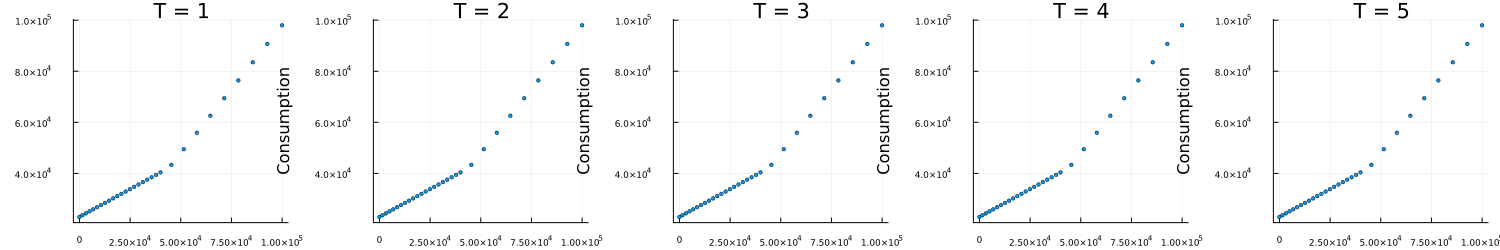

In [45]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_c
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid, hc_mid],
        xlabel = "Assets",
        ylabel = "Consumption",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))

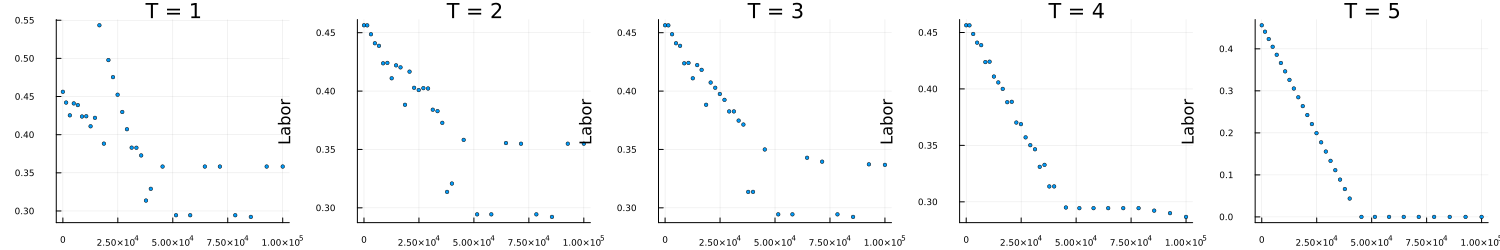

In [46]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_h
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid, hc_mid],
        xlabel = "Assets",
        ylabel = "Labor",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))